### Identification and Classification of Fries with Defects using Images ###

**1. Problem Statement:**

An organization is looking to automate thr process of identifying defects in a set of french fries, and classifying them into one of four categories based on the size of these defects.

**3. Data Available:**

The available consists of the following:
- 265 Images of sets of Fries for Training purposes
- A CSV file with filenames, the associated Defects Classes, and the X-Y Pixel Location for the 265 Training Images
- 10 Images of sets of Fries for Testing purposes

**2. Objective:**

Design a workflow and algorithm which takes captured images of fries, analyzes these images, and identifies, with maximum accuracy, the following:
1. The areas where the defects are
2. The Class of these defects, based on their size

Apply both Deep Machine Learning and Feature Engineering based approaches

### Approach ###

Based on the problem statement, objectives, and data available, this problem may be solved using one or more (i.e., a combination) of the following methods:
- Image Classification
- Image Segmentation
- Transfer Learning
- Feature Engineering / Image Processing

### Assumptions & Metrics ###

The following assumptions have been made in the tecniques used in this project:
- No metric has been provided as a threshold for prediction accuracy. Therefore, accuracies have been defined below based on the technique employed. It is assumed that:
 - For Image Segmentation / Defect Localization, 80% or above is considered "good enough".
 - For Classification, 70% or above is considered "good enough"
 Once these accuracy thresholds have been reached, further fine-tuning is left to a future optimzation process
- Maximize the usage of the datasets in order to generate a valid generation solution. Choosing only a subset of the dataset, although it may improve accuracy for the purposes of this project, would lead to a less generalized practical solution.

For the purposes of training the models, and in order to evaluate their veracity, we will use the following metrics:
- For Classification: Validation Set Accuracy, Precision, and Recall scores (and the combined F1 score). It is important to measure the Precision and Recall when a dataset is skewed or biased (high occurence of a label), leading to false high-accuracy ratings.
- For Image Segmentation: Validation Set Accuracy


In [7]:
# Loading libraries, frameworks, and magic
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm 
from PIL import Image as PIL_Image
from datetime import datetime
import numpy as np
import matplotlib.image as mpimg
import random
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import cv2
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, svm, metrics

# Importing Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Convolution2D #Videos are 3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from keras.models import Model, load_model
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

### Data Pre-Processing ###

We will begin with analyzing the data on hand. Based on the information obtained from data analysis, it can be determined which type of approach is best, and what the issues may be.

In [8]:
project_root_folder = 'drive/My Drive/SavormetricsTest1/'
path = project_root_folder + 'Data_label.csv'
train_labels = pd.read_csv(path)

train_labels.rename(columns={'Label':'ClassId'}, inplace = True)
train_labels.rename(columns={'Image number':'ImageId'}, inplace = True)

train_labels.head()

ImageId ClassId     X     Y  Radius
0      220       A  1773  1453       6
1      220       A   421  1679       6
2      220       A   452   538       6
3      220       C  1098  1233      28
4      220       A   486   517       6

In [9]:
path = project_root_folder + 'Test_Labels.csv'
test_image_names = pd.read_csv(path).T
test_image_names.index.name = 'ImageId'
test_image_names.reset_index(inplace=True)
test_image_names.head()

ImageId
0  1008.png
1  1011.png
2  1062.png
3  1095.png
4  1098.png

In [35]:
### DATA PRE-PROCESSING ###

X_master = train_labels
X_master = X_master[['ImageId','ClassId']]
X_master = X_master.drop_duplicates(subset=None, keep='first', inplace=False)

X_master_OHE = X_master.copy()
X_master_OHE['A'] = X_master_OHE['ClassId'][X_master['ClassId'] == 'A']
X_master_OHE['B'] = X_master_OHE['ClassId'][X_master['ClassId'] == 'B']
X_master_OHE['C'] = X_master_OHE['ClassId'][X_master['ClassId'] == 'C']
X_master_OHE['D'] = X_master_OHE['ClassId'][X_master['ClassId'] == 'D']
X_master_OHE = X_master_OHE.fillna(value=0)
X_master_OHE = X_master_OHE.replace(to_replace='A', value=1)
X_master_OHE = X_master_OHE.replace(to_replace='B', value=1)
X_master_OHE = X_master_OHE.replace(to_replace='C', value=1)
X_master_OHE = X_master_OHE.replace(to_replace='D', value=1)
X_master_OHE = X_master_OHE.drop(columns=['ClassId'])
X_master_OHE['ImageId'] = X_master_OHE['ImageId'].astype(str) + '.png'

X_master = X_master.fillna(value=0)
X_master = X_master.pivot(index='ImageId', columns='ClassId', values='ClassId')
X_master = X_master.fillna(value=0)
X_master = X_master.replace(to_replace='A', value=1)
X_master = X_master.replace(to_replace='B', value=1)
X_master = X_master.replace(to_replace='C', value=1)
X_master = X_master.replace(to_replace='D', value=1)
X_master.index.name = 'ImageId'
X_master.reset_index(inplace=True)
X_master['ImageId'] = X_master['ImageId'].astype(str) + '.png'
# X_master = X_master.drop(columns=['ClassId'])

training_split = int(0.8*len(X_master))
val_split = len(X_master) - training_split

X_master.head()

ClassId  ImageId  A  B  C  D
0        220.png  1  1  1  0
1        222.png  1  1  1  1
2        223.png  1  1  1  1
3        224.png  1  1  1  1
4        226.png  0  1  1  1

In [11]:
# Setting Original and Resized Image Heights

IMG_ORIG_HEIGHT = 2048
IMG_ORIG_WIDTH = 2448

IMG_COMP_HEIGHT = 256
IMG_COMP_WIDTH = 512

### Data Analysis ###

No. of Images in train set:  265 
 --------------------------------------------------


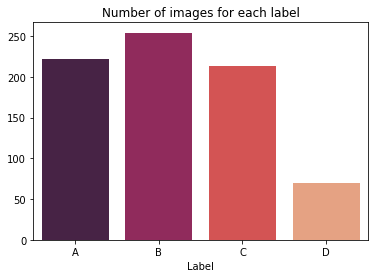

No. of Images having: Label A = 222, Label B = 254, Label C = 213, Label D = 70 
 --------------------------------------------------


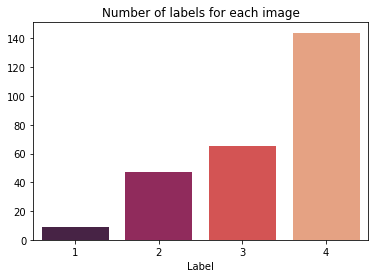

No. of Images with 1 label: 9, with 2 labels: 65, with 3 labels: 144, with 4 labels: 47


In [194]:
### DATA ANALYSIS ###

print("No. of Images in train set: ", X_master.shape[0],'\n','-'*50)

tmp = [sum(X_master['A']==1),
       sum(X_master['B']==1),
       sum(X_master['C']==1),
       sum(X_master['D']==1)]
fig, ax = plt.subplots()
sns.barplot(x=['A','B','C','D'],y=tmp,palette = "rocket")
ax.set_title("Number of images for each label")
ax.set_xlabel("Label")
plt.show()
print("No. of Images having: Label A = {}, Label B = {}, Label C = {}, Label D = {}".format(tmp[0],tmp[1],tmp[2],tmp[3]),'\n','-'*50)

tmp = (X_master['A']+X_master['B']+X_master['C']+X_master['D']).value_counts()
fig, ax = plt.subplots()
sns.barplot(x=['4','3','2','1'],y=tmp,palette = "rocket")
ax.set_title("Number of labels for each image")
ax.set_xlabel("Label")
plt.show()
print("No. of Images with 1 label: {}, with 2 labels: {}, with 3 labels: {}, with 4 labels: {}".format(tmp[1],tmp[2],tmp[3],tmp[4]))


Sample Image from the Training Dataset:


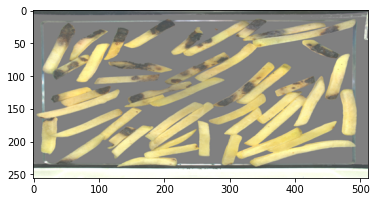

In [193]:
print('Sample Image from the Training Dataset:')
idx = random.randint(0, len(X_master))
sample_img = mpimg.imread(project_root_folder + '/Resized/real/' + str(X_master.iloc[idx]['ImageId']))
plt.imshow(sample_img)
plt.show()

Data analysis outlines two key features of this dataset:

1. The defect classes are not equally distributed. A large majority of images have Class A, B, and C defects, and most images have 3 or more types of defects.
2. The defects themselves are a small percentage of the overall image (i.e., the size of the defects is small compared with the size of the image).

**Impacts for Classification:**
The large percentage of images with Class A, B, and C defects would cause most learning algorithms to "overfit" the data by tending bias towards identifying these defects in all images.
 
 **Impacts for Image Segmentation:**
For image segmentation, the fact that the defects make up a small percentage of the overall image should lead to good learning results.

**Mitigation Strategies for Classification Overfitting:**
This issue may be resolved using one or more of the following methods:
1. Obtaining a dataset with more evenly distributed defects, leading to a less biased training set. 
2. Onbtaining a dataset with more unique defects (i.e., dataset where the number of images containing more than 1 defect is low). This may not be practical, as defects may tend to "cluster".
3. Training the model on a subset of the dataset which has been designed for a more even distribution. This method is the most practical, however, due to the small size of the dataset, this approach may not work for the given dataset.
4. Avoid using the class labels to train an algorithm. Instead, first use Image Segmentation to identify the defect areas, then use this information to calculate the size of the defected area, and use this size information to Classify the defects. Note, this is the method that gives the most accurate results in the below techniques.

In [14]:
# Define the areas of different classes
pi = 3.14159
area_D = pi*48
area_C = pi*28
area_B = pi*12
area_A = pi*6

range_A = [area_A*0.8, area_A + (area_B-area_A) / 2]
range_B = [range_A[1], area_B + (area_C-area_B) / 2]
range_C = [range_B[1], area_C + (area_D-area_C) / 2]
range_D = [range_C[1], area_D*3]

### Image Transformations and Mask Generation ###

The images in the Dataset are 2048 x 2448, which is large and makes them difficult to work with on limited computation resources. Furthermore, after the first iteration of Mask Generation, it was found that the images are Rotated 180 degrees about the center.

In order to save computation resources and run time, the following Transformations are applied to the images and sotred in the Hard Drive.
- Image Rotation
- Mask Generation using the X-Y and Radius information provided
- Image Resizing to 256 x 512
- Mask Resizing to 256 x 512

Please note that, for production-level software, these transformations would be part of the Data Processing Pipeline, and would happen 'live' during runtime.

Image Transformation and Mask Generation Flow

![Picture](https://raw.githubusercontent.com/rohaan-ahmed/Master-Repository/master/Savormetrics/Flow%20Diagrams/Image%20Processing.png)

In [ ]:
### IMAGE TRANSFORMATION AND MASK CREATION ###

''' We store data to the Hard Drive to avoid running this every time
In Production Level software, this would be part of the online pipeline'''

# # Writing test image names to a csv
# test_image_names = os.listdir(test_path)
# with open('Test_Labels.csv', 'w', newline='') as test_csv:
#      wr = csv.writer(test_csv, quoting=csv.QUOTE_ALL)
#      wr.writerow(test_image_names)
     
# '''Creating Masks for Each Image, and saving them on the hard drive'''

# items = 0
# while items < len(train_labels):
#     # print('Image: ' + str(items))
#     l = items
#     m = l
#     mask = np.zeros((IMG_ORIG_HEIGHT, IMG_ORIG_WIDTH), dtype=np.int)
#     while ( m != len(train_labels) and (train_labels.iloc[l]['ImageId'] == train_labels.iloc[m]['ImageId']) ):
        
#         x_0 = train_labels.iloc[m]['X']
#         y_0 = train_labels.iloc[m]['Y']
#         if train_labels.iloc[m]['ClassId'] == 'A':
#             r = 6
#         elif train_labels.iloc[m]['ClassId'] == 'B':
#             r = 12
#         elif train_labels.iloc[m]['ClassId'] == 'C':
#             r = 28
#         elif train_labels.iloc[m]['ClassId'] == 'D':
#             r = 48
        
#         y_start = max(0, y_0 - r)
#         y_stop = min(IMG_ORIG_WIDTH, y_0 + r)
#         x_start = max(0, x_0 - r)
#         x_stop = min(IMG_ORIG_HEIGHT, x_0 + r)
        
        
#         for i in range(y_start, y_stop):
#             for j in range(x_start, x_stop):
#                 mask[i][j] = 256
#         m = m+1
#     im = PIL_Image.fromarray(mask)
#     im.save('Training Images Masks/' + str(train_labels.iloc[l]['ImageId']) + 'mask.png')
#     items = m
    
# '''Load and Plot Random Image and its Mask'''

# import random
# idx = random.randint(0, len(X_train))
# img1=mpimg.imread(train_path + str(train_labels.iloc[idx]['ImageId']) + '.png')
# plt.imshow(img1)
# img2=mpimg.imread('Training Images Masks/' + str(train_labels.iloc[idx]['ImageId']) + 'mask.png')
# plt.imshow(img2, cmap='gray', alpha=0.75) # interpolation='none'
# plt.show()

# '''Resizing the training images and masks, and saving them on the hard drive'''
# print('Resizing images and masks')
# for n in range (0,len(X_master)):
# # for n in range (0,20):
#     # print('Image: ' + str(X_master.iloc[n]['ImageId']))
#     path = train_path + str(X_master.iloc[n]['ImageId'])
#     img = PIL_Image.open(path)
#     img = img.resize((IMG_COMP_WIDTH, IMG_COMP_HEIGHT))
#     img.save('Resized/real/' + str(X_master.iloc[n]['ImageId']))
    
#     path = 'Training Images Masks/' + str(X_master.iloc[n]['ImageId']).replace(".png", "") + 'mask.png'
#     mask = PIL_Image.open(path)
#     mask = mask.resize((IMG_COMP_WIDTH, IMG_COMP_HEIGHT))
#     mask.save('Resized/masks/' + str(X_master.iloc[n]['ImageId']))

# '''Resizing the test images, and saving them on the hard drive'''
# for n in range (0,len(test_image_names)):
#     path = test_path + str(test_image_names[n])
#     img = PIL_Image.open(path)
#     img = img.resize((IMG_COMP_WIDTH, IMG_COMP_HEIGHT))
#     img.save('Resized/TestImages/' + str(test_image_names[n]))

**In subsequent sections, we will employ several different types of techniques to solve the problem.**

Please note that the sections are in order of convenience, and have no preferred ordering

### Multi-Class Classification using the Xception Model from Keras with Pre-trained Weights from Imagenet (MCX) ###

In this method, we will employ the Transfer Learning method to a Multi-Class Classification Problem. 

We will use Google's Xception model available via the Keras Deep Learning Library as a base model and add our own top layers, consisting fully-connected and output layers. We will then use this new model to classify the images directly, without using any masking. To maximize the benefit of the base model, we will use pre-trained weights generated with the famous ImageNet dataset fo Object Detection, and "freeze" these weights (i.e., we will not train the base model).

The Xception model is a modified depthwise separable convolution technique which performs pointwise convolution followed by a depthwise convolution, as shown in Figure MCX1 and Figure MCX2.

Figure MCX1
![picture](https://miro.medium.com/max/700/1*J8dborzVBRBupJfvR7YhuA.png)
Figure MCX2
![picture](https://miro.medium.com/max/700/1*hOcAEj9QzqgBXcwUzmEvSg.png)

We selected Xception because it is a light-weight (relatively) model with very good performance [link text](https://keras.io/api/applications/#xception)



Figure MCX3 shows the Flow Diagram of the algorithm we are implementing Algorithm

Figure MCX3
![Picture](https://raw.githubusercontent.com/rohaan-ahmed/Master-Repository/master/Savormetrics/Flow%20Diagrams/MCX.png)

In [38]:
### MULTI-CLASS CLASSIFICATION USING XCEPTION WITH PRETRAINED MODEL WEIGHTS (MCX) ###

training_split = int(0.8*len(X_master_OHE))
val_split = len(X_master_OHE) - training_split

X_train = X_master_OHE.iloc[:training_split][:]
X_val = X_master_OHE.iloc[-val_split:][:]

model_directory = project_root_folder + 'Resized/real/'

X_train.head()

ImageId  A  B  C  D
0   220.png  1  0  0  0
3   220.png  0  0  1  0
5   220.png  0  1  0  0
14  222.png  1  0  0  0
18  222.png  0  0  1  0

In [16]:
# Metrics Functions for Evaluation
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

def recall_m(y_true, y_pred):
    '''
    This function returns recall_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns recall score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
    return recall

def precision_m(y_true, y_pred):
    '''
    This function returns precison_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns prediction score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
    precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
    return precision
    
def f1_score_m(y_true, y_pred):
    '''
    This function returns f1_score between y_true and y_pred
    This 
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns f1 score of the batch
    '''
    precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
    recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'recall_m':recall_m,
    'precision_m':precision_m,
    'f1_score_m':f1_score_m,
}

In [39]:
# DataGenerator for the multi label classification model with image augmentations
# The augmentations applied include random resizing, shearing, rotation, and flipping.

train_DataGenerator = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                            width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

train_generator = train_DataGenerator.flow_from_dataframe(
        dataframe=X_train,
        directory=model_directory,
        x_col="ImageId",
        y_col=["A","B","C","D"],
        target_size=(512,256),
        batch_size=20,
        class_mode='raw')

test_DataGenerator = ImageDataGenerator()

validation_generator = test_DataGenerator.flow_from_dataframe(
        dataframe=X_val,
        directory=model_directory,
        x_col="ImageId",
        y_col=["A","B","C","D"],
        target_size=(512,256),
        batch_size=20,
        class_mode='raw')

Found 607 validated image filenames.
Found 152 validated image filenames.


In [40]:
# Using a pretrained model from keras for classification: 
# Selected Xception model, without its output layer, and locking its weights
# Example of Transfer Learning
# https://keras.io/applications/

base_model_MCX = keras.applications.xception.Xception(include_top = False, weights="imagenet", input_shape = (512,256,3))
base_model_MCX.trainable = False

# Adding custom layers for our Classification problem: 
    
# Global spatial average pooling layer
x = base_model_MCX.output
x = GlobalAveragePooling2D()(x)

# Fully-connected layers
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)

# Prediction/output layer
predictions = Dense(4, activation='sigmoid')(x)

# Initializing the Model
MCX_model = Model(inputs=base_model_MCX.input, outputs=predictions)
MCX_model.summary()

MCX_model.compile(optimizer='adam', loss='CategoricalCrossentropy',metrics=['acc',f1_score_m,precision_m,recall_m])
epochs = 30

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 127, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [41]:
# Training the Model
logdir = 'logs/' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_MCX'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
mc = ModelCheckpoint('logs/model.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)

history = MCX_model.fit(train_generator, validation_data = validation_generator, epochs = epochs, verbose=1)

file_writer.close()

Epoch 1/30
31/31 [==============================] - 22s 700ms/step - loss: 1.4032 - acc: 0.2801 - f1_score_m: 0.4023 - precision_m: 0.2806 - recall_m: 0.7203 - val_loss: 4.8527 - val_acc: 0.2829 - val_f1_score_m: 0.4100 - val_precision_m: 0.3066 - val_recall_m: 0.6188
Epoch 2/30
31/31 [==============================] - 20s 658ms/step - loss: 1.3389 - acc: 0.3229 - f1_score_m: 0.4496 - precision_m: 0.2959 - recall_m: 0.9371 - val_loss: 3.2725 - val_acc: 0.2500 - val_f1_score_m: 0.4271 - val_precision_m: 0.2847 - val_recall_m: 0.8542
Epoch 3/30
31/31 [==============================] - 20s 659ms/step - loss: 1.3058 - acc: 0.3443 - f1_score_m: 0.4381 - precision_m: 0.2849 - recall_m: 0.9488 - val_loss: 2.0097 - val_acc: 0.3158 - val_f1_score_m: 0.3839 - val_precision_m: 0.2601 - val_recall_m: 0.7333
Epoch 4/30
31/31 [==============================] - 21s 665ms/step - loss: 1.3044 - acc: 0.3493 - f1_score_m: 0.4343 - precision_m: 0.2815 - recall_m: 0.9502 - val_loss: 2.6234 - val_acc: 0.250

In [42]:
# Saving model to HD to from computing each time
MCX_model.save(project_root_folder + 'Models/MCX_model_OHE.h5')

In [ ]:
# Loading model from HD
MCX_model = keras.models.load_model(project_root_folder + 'Models/MCX_model_OHE.h5')

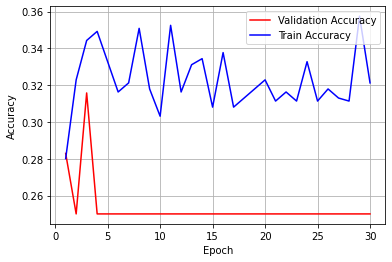

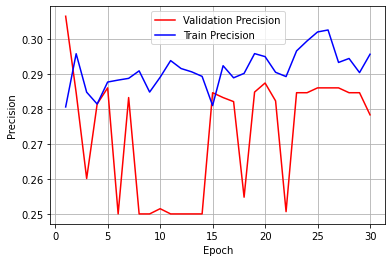

In [46]:
# plot "accuracy" vs epoch
vy = history.history['val_acc']
ty = history.history['acc']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation Accuracy")
ax.plot(x,ty,'b',label = "Train Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# plot "accuracy" vs epoch
vy = history.history['val_precision_m']
ty = history.history['precision_m']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation Precision")
ax.plot(x,ty,'b',label = "Train Precision")
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

In [47]:
# Testing on Validation Images
X_temp = X_val.copy()
X_temp['A'] = X_temp['B'] = X_temp['C'] = X_temp['D'] = int(0)

test_generator = test_DataGenerator.flow_from_dataframe(
        dataframe=X_temp,
        directory=model_directory,
        x_col="ImageId",
        y_col=["A","B","C","D"],
        target_size=(512,256),
        batch_size=2,
        class_mode='raw')

MCX_pred_perc_val = MCX_model.predict(test_generator,verbose=1)
MCX_pred_val = (MCX_pred_perc_val > 0.5).astype(np.uint8)
MCX_pred_val[0:10]

Found 152 validated image filenames.
76/76 [==============================] - 2s 25ms/step


array([[1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0]], dtype=uint8)

In [48]:
# Confution Matrix for each Label
print('Confusion Matrix A\n' + str(cm(X_val['A'], MCX_pred_val[:,0])))
print('Confusion Matrix B\n' + str(cm(X_val['B'], MCX_pred_val[:,1])))
print('Confusion Matrix C\n' + str(cm(X_val['C'], MCX_pred_val[:,2])))
print('Confusion Matrix D\n' + str(cm(X_val['D'], MCX_pred_val[:,3])))

Confusion Matrix A
[[  0 114]
 [  0  38]]
Confusion Matrix B
[[  0 104]
 [  0  48]]
Confusion Matrix C
[[  0 108]
 [  0  44]]
Confusion Matrix D
[[121   9]
 [ 18   4]]


In [ ]:
print('Validation Table:\n' + str(X_val.head()))
print('Prediction Table:\n' + str(MCX_pred_val[0:5]))

Validation Table:
ClassId   ImageId  A  B  C  D
212      1047.png  0  1  0  1
213      1048.png  0  1  1  1
214      1049.png  1  1  1  0
215      1050.png  0  1  1  1
216      1051.png  1  0  1  1
Prediction Table:
[[0 1 1 1]
 [0 1 1 1]
 [1 1 1 0]
 [0 1 1 1]
 [1 1 1 0]]


In [49]:
# Testing on Test Images
X_test = pd.DataFrame(test_image_names)
X_test.rename(columns={0:'ImageId'}, inplace = True)
X_test['A'] = X_test['B'] = X_test['C'] = X_test['D'] = int(0)

test_generator = test_DataGenerator.flow_from_dataframe(
        dataframe=X_test,
        directory= project_root_folder + 'Resized/TestImages/',
        x_col="ImageId",
        y_col=["A","B","C","D"],
        target_size=(512,256),
        batch_size=2,
        class_mode='raw')

MCX_pred_perc_test = MCX_model.predict(test_generator,verbose=1)
MCX_pred_test = (MCX_pred_perc_test > 0.5).astype(np.uint8)

MCX_pred_test[0:5]

Found 10 validated image filenames.
5/5 [==============================] - 3s 688ms/step


array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0]], dtype=uint8)

**Observations:**

It can be seen that the MCU approach did not generate good accuracy (inconsistent %age) or precision (less than 50%), despite using a well-trained base model. The model, as hypothesized earlier, "overfit" on the Class data, and tended to bias towards Class A, B, and C defects.

This problem can be mitigated using some of the mitigation strategies mentioned earlier

### Image Segmentation Using U-Net (ISUnet)###

In this section, we will use a well known Image Segmentation Architecture, known as U-net, to identify areas of Defects. We will NOT be using Transfer Learning, and will create the entire Neural Network from scratch. All model weights will initialized randomly and will be trained using the dataset.

Unet is a Convolutional Neural Network (CNN) designed specifically for processing biomedical images, where localizing is necessary. Unike traditional CNNs, the primary goal of this network is not Classification, but identifying where the abnormality is on the image. This makes it perfectly suited for the current task.

UNet has two sub-sections, a Contraction Path and an Expansion Path, as seen in Figure ISUNet 1. In this way, it resembles an Autoencoder.

Figure ISUNet 1
![picture](https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png)

We will NOT be Classifying the defects in this section.

In [ ]:
### IMAGE SEMENTATION USING U-NET (ISUnet)###

# Loading training images and masks from the hard drive
# X_master2 = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH, 3), dtype=np.uint8)
# Y_master2 = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH), dtype=np.uint8)
# for n in range (0,len(X_master)):
#     path = project_root_folder + 'Resized/real/' + str(X_master.iloc[n]['ImageId'])
#     img = PIL_Image.open(path)
#     X_master2[n] = img
# 
#     path = project_root_folder + 'Resized/masks/' + str(X_master.iloc[n]['ImageId'])
#     mask = PIL_Image.open(path)
#     Y_master2[n] = mask

In [ ]:
# # Saving X_master2 and Y_master2 to HD because they always taks long to compute
# f = open(project_root_folder + 'Resized/Transformed/X_master2.pkl', 'wb')
# pickle.dump(X_master2, f)
# 
# f.close()
# f = open(project_root_folder + 'Resized/Transformed/Y_master2.pkl', 'wb')
# pickle.dump(Y_master2, f)
# f.close()

In [53]:
# Loading X_master2 and Y_master2 to HD
f = open(project_root_folder + 'Resized/Transformed/X_master2.pkl', 'rb')
X_master2 = pickle.load(f)
f.close()
f = open(project_root_folder + 'Resized/Transformed/Y_master2.pkl', 'rb')
Y_master2 = pickle.load(f)
f.close()

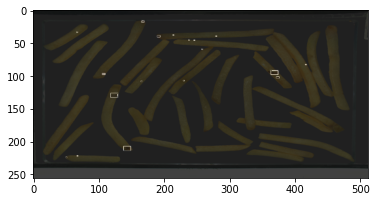

In [55]:
# plotting a random image and mask
idx = random.randint(0, len(X_master2))
img1 = X_master2[idx]
img2 = Y_master2[idx]
plt.imshow(img1)
plt.imshow(img2, cmap='gray', alpha=0.75)
plt.show()

In [56]:
# Building the UNet Model
# https://github.com/zhixuhao/unet/blob/master/model.py

inputs = tf.keras.layers.Input((IMG_COMP_HEIGHT, IMG_COMP_WIDTH, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
ISUnet_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
ISUnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ISUnet_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 512, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 256, 512, 16) 0           conv2d_12[0][0]                  
_______________________________________________________________________________________

In [58]:
# Training the Model
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_segmentation.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results = ISUnet_model.fit(X_master2, Y_master2, validation_split=0.2, batch_size=10, epochs=30, callbacks=callbacks)
results = ISUnet_model.fit(X_master2, Y_master2, validation_split=0.2, batch_size=30, epochs=30)

Epoch 1/30
8/8 [==============================] - 6s 716ms/step - loss: 0.5370 - accuracy: 0.9791 - val_loss: 1.3185 - val_accuracy: 0.9834
Epoch 2/30
8/8 [==============================] - 4s 483ms/step - loss: 0.5109 - accuracy: 0.8389 - val_loss: 1.2494 - val_accuracy: 0.8499
Epoch 3/30
8/8 [==============================] - 4s 486ms/step - loss: 0.4447 - accuracy: 0.8386 - val_loss: 0.6540 - val_accuracy: 0.6200
Epoch 4/30
8/8 [==============================] - 4s 487ms/step - loss: 0.3938 - accuracy: 0.7951 - val_loss: 0.7534 - val_accuracy: 0.6272
Epoch 5/30
8/8 [==============================] - 4s 488ms/step - loss: 0.3133 - accuracy: 0.7308 - val_loss: 1.4557 - val_accuracy: 0.6646
Epoch 6/30
8/8 [==============================] - 4s 491ms/step - loss: -0.0221 - accuracy: 0.7168 - val_loss: 2.6674 - val_accuracy: 0.6541
Epoch 7/30
8/8 [==============================] - 4s 491ms/step - loss: -0.4779 - accuracy: 0.8237 - val_loss: 2.2510 - val_accuracy: 0.6756
Epoch 8/30
8/8 [==

In [59]:
# Saving model to HD to from computing each time
ISUnet_model.save(project_root_folder + 'Models/ISUnet_model.h5')

In [ ]:
# Loading model from HD
ISUnet_model = keras.models.load_model(project_root_folder + 'Models/ISUnet_model.h5')

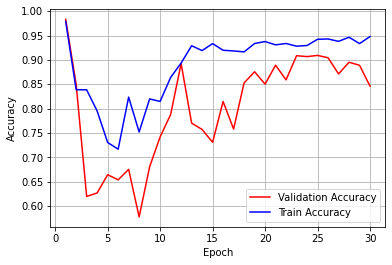

In [60]:
# plot on "accuracy" vs epoch
vy = results.history['val_accuracy']
ty = results.history['accuracy']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation Accuracy")
ax.plot(x,ty,'b',label = "Train Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

8/8 [==============================] - 2s 189ms/step


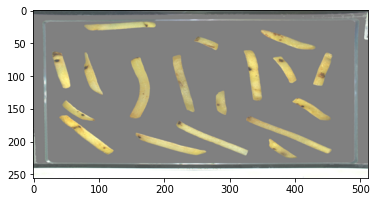

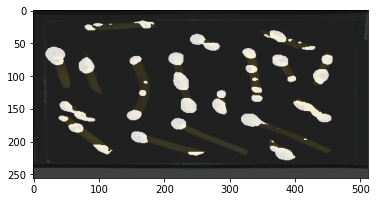

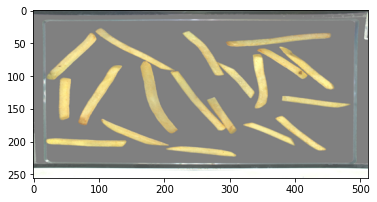

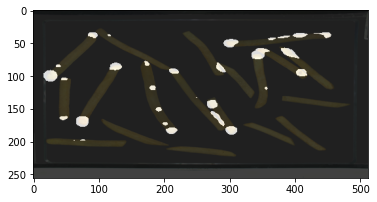

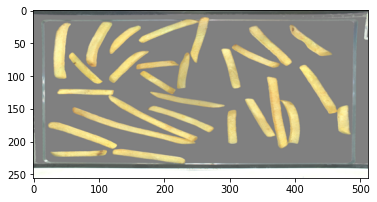

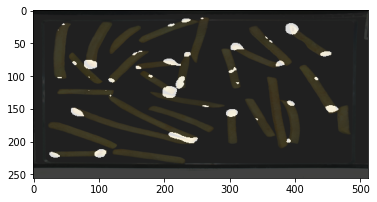

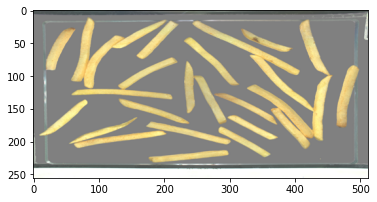

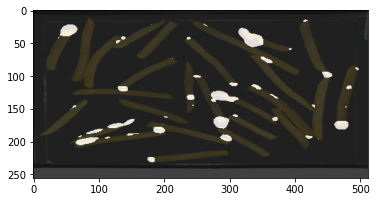

In [61]:
# Testing on a random Validation Images
idx = random.randint(0, len(X_master2))

pred_perc_ISUnet = ISUnet_model.predict(X_master2[:int(X_master2.shape[0]*0.9)], verbose=1)
pred_ISUnet = (pred_perc_ISUnet > 0.5).astype(np.uint8)

idx = random.randint(4, len(pred_ISUnet))

for ix in range (idx-4, idx):
  plt.imshow(X_master2[ix])
  plt.show()

  plt.imshow(X_master2[ix])
  plt.imshow(np.squeeze(pred_ISUnet[ix]), cmap='gray', alpha=0.75)
  plt.show()

1/1 [==============================] - 0s 62ms/step


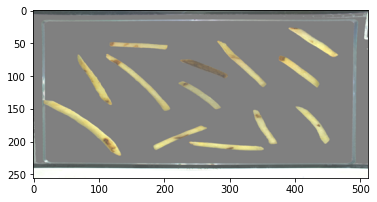

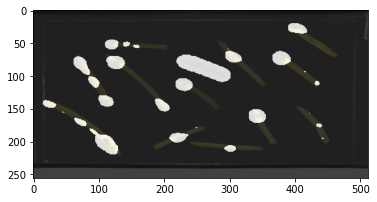

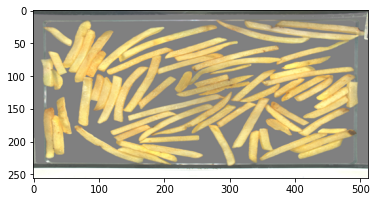

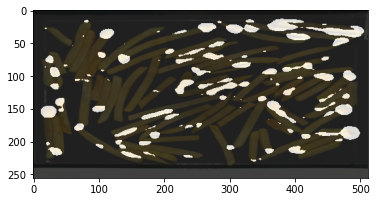

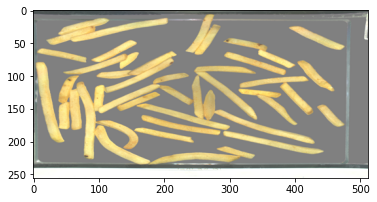

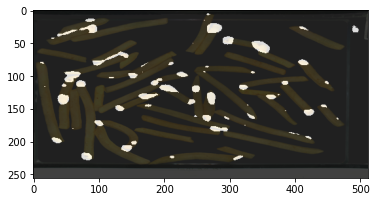

In [63]:
# Testing on Test Image     
test_image_names2 = np.array(test_image_names)
X_test = np.zeros((len(test_image_names), IMG_COMP_HEIGHT, IMG_COMP_WIDTH,3), dtype=np.uint8)
test_image_names2 = test_image_names['ImageId'].astype(str)
for n in range (0,len(test_image_names)):
    path = project_root_folder + 'Resized/TestImages/' + str(test_image_names2[n])
    img = PIL_Image.open(path)
    X_test[n] = img

pred_perc_ISUnet_test = ISUnet_model.predict(X_test[:], verbose=1)
pred_ISUnet = (pred_perc_ISUnet_test > 0.5).astype(np.uint8)

idx = random.randint(2, len(pred_ISUnet))

for ix in range (idx-3, idx):
  plt.imshow(X_test[ix])
  plt.show()

  plt.imshow(X_test[ix])
  plt.imshow(np.squeeze(pred_ISUnet[ix]), cmap='gray', alpha=0.75)
  plt.show()

**Observations:**

It can be seen that the accuracy obtained by using Unet for Image Segmentation is over 90%. In all the test images observed, the area of defects was accurately identified.

Fine tuning this model would lead to better results. Furthermore, this model may be used as part of a pipeline for the task of Classification as well.

### Binary Classifier with Exception For Only 1 Class (BCX)  ###

In this section, we will once again use the Xception model, but to only classify One defect at a time.

As was previously observed, one of the issues with using Xception for Multi-Class Classification using the current dataset was that the model was biased towards identifying certain defects (due to their large numbers).

In this section, we change the model slightly such that, instead of trying to classify between 4 different classes, the model now only has to identify whether a single defect class exists or not. More specifically, we train the model only one one class of defects, and ask it to make a probabilistic estimate of whether that single class exists in the test images or not (output layer is 1 perceptron, instead of 4)

In [ ]:
### BINARY CLASSIFIER WITH XCEPTION FOR ONLY 1 CLASS (BCX)  ### 
### Using Defect Class C
# Similar code to MCX

training_split = int(0.8*len(X_master))
val_split = len(X_master) - training_split

X_train = X_master.iloc[:training_split][:]
X_val = X_master.iloc[-val_split:][:]

Found 212 validated image filenames.
Found 53 validated image filenames.
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 127, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 127, 32) 0           block1_conv1_bn[0][0]            
_____________

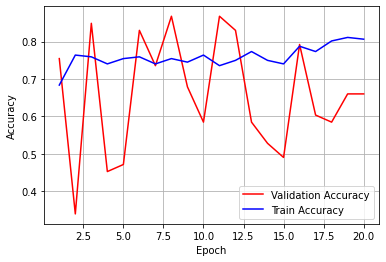

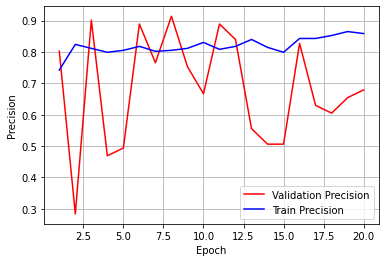

Found 53 validated image filenames.
27/27 [==============================] - 1s 22ms/step
Confusion Matrix:
[[ 4  3]
 [17 29]]


In [65]:

train_DataGenerator = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                            width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

train_generator = train_DataGenerator.flow_from_dataframe(
        dataframe=X_train,
        directory=project_root_folder + 'Resized/real/',
        x_col="ImageId",
        y_col=["C"],
        target_size=(512,256),
        batch_size=2,
        class_mode='raw')

test_DataGenerator = ImageDataGenerator(rescale=1./255)

validation_generator = test_DataGenerator.flow_from_dataframe(
        dataframe=X_val,
        directory=project_root_folder + 'Resized/real/',
        x_col="ImageId",
        y_col=["C"],
        target_size=(512,256),
        batch_size=2,
        class_mode='raw')

base_model_BCX = keras.applications.xception.Xception(include_top = False, weights="imagenet", input_shape = (512,256,3))
base_model_BCX.trainable = False

x = base_model_BCX.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)

model_BCX = Model(inputs=base_model_BCX.input, outputs=predictions)
model_BCX.summary()

model_BCX.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc',f1_score_m,precision_m,recall_m])
epochs = 20

logdir = 'logs/' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_multi_classification'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
mc = ModelCheckpoint('logs/model.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)
history = model_BCX.fit(train_generator, validation_data = validation_generator, epochs = epochs, verbose=1)
file_writer.close()

In [68]:
# Saving model to HD to from computing each time
model_BCX.save(project_root_folder + 'Models/BCX_model.h5')

In [ ]:
# Loading model from HD
model_BCX = keras.models.load_model(project_root_folder + 'Models/BCX_model.h5')

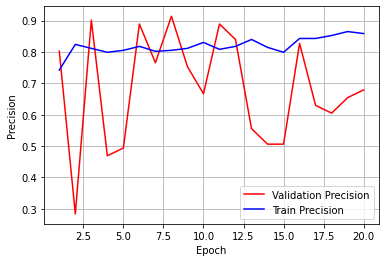

Found 53 validated image filenames.
27/27 [==============================] - 1s 25ms/step
Confusion Matrix:
[[ 1  6]
 [20 26]]
Accuracy: 50.94


In [71]:
# plot on "val_f1_score_m" vs epoch
vy = history.history['val_f1_score_m']
ty = history.history['f1_score_m']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation Precision")
ax.plot(x,ty,'b',label = "Train Precision")
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
plt.legend()
plt.grid()
plt.show()  

# Testing on Validation Images
X_temp_orig = X_val[['ImageId','C']]
X_temp = X_temp_orig.copy()
X_temp['C'] = int(0)

test_generator = test_DataGenerator.flow_from_dataframe(
        dataframe=X_temp,
        directory=project_root_folder + 'Resized/real/',
        x_col="ImageId",
        y_col=["C"],
        target_size=(512,256),
        batch_size=2,
        class_mode='raw')

pred_perc_BCX = model_BCX.predict(test_generator,verbose=1)
pred_BCX = (pred_perc_BCX > 0.5).astype(np.uint8)

confusion_matrix = cm(X_val['C'], pred_BCX[:,0])
print('Confusion Matrix:\n' + str(confusion_matrix))
accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1]) * 100
print('Accuracy: ' + str(round(accuracy,2)))

**Observations:**

Using Xception for binary classification yields slightly better results. However, the data is still overfitting owing to the large number of Class C defects found in the dataset. These may be mitigated using some of the strategies outlined above.

### Multi-Class Classification with Xception with Image Segmentation using ISUNet (MCXISU) ###

In this section, we combine the above two approaches in order to first localize the defect using ISUNet, and then classify it using Xception. 

ISUnet is trained on the training images and training masks, and is used to generate a mask for the test images. 

Xception is trained on training masks and defect labels, and is used to generate labels for the generated masks.

The objective is to see if combining the two approaches above yield better Classification results.

Figure MCXISU-1 shows the Flow Diagram of this Algorithm

Figure MCXISU-1
![Picture](https://raw.githubusercontent.com/rohaan-ahmed/Master-Repository/master/Savormetrics/Flow%20Diagrams/MCXISU.png)

In [72]:
X_train = X_master.iloc[:training_split][:]
X_val = X_master.iloc[-val_split:][:]

# DataGenerator for the multi label classification model with image augmentations

train_DataGenerator = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.05, rotation_range=5,
                            width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

train_generator = train_DataGenerator.flow_from_dataframe(
        dataframe=X_train,
        directory= project_root_folder + 'Resized/masks/',
        x_col="ImageId",
        y_col=["A","B","C","D"],
        target_size=(512,256),
        batch_size=10,
        class_mode='raw')

test_DataGenerator = ImageDataGenerator(rescale=1./255)

validation_generator = test_DataGenerator.flow_from_dataframe(
        dataframe=X_val,
        directory= project_root_folder + 'Resized/masks/',
        x_col="ImageId",
        y_col=["A","B","C","D"],
        target_size=(512,256),
        batch_size=10,
        class_mode='raw')

Found 212 validated image filenames.
Found 53 validated image filenames.


In [73]:
# Using a pretrained model from keras for classification: 
# Selected Xception model, without its output layer, and locking its weights
# Example of Transfer Learning
# https://keras.io/applications/

base_model_MCXISU = keras.applications.xception.Xception(include_top = False, weights="imagenet", input_shape = (512,256,3))
base_model_MCXISU.trainable = False

# Adding custom layers for our Classification problem: 
    
# Global spatial average pooling layer
x = base_model_MCXISU.output
x = GlobalAveragePooling2D()(x)

# Fully-connected layers
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# Prediction/output layer
predictions = Dense(4, activation='sigmoid')(x)

# Initializing the Model
MCXISU_model = Model(inputs=base_model_MCXISU.input, outputs=predictions)
MCXISU_model.summary()

MCXISU_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc',f1_score_m,precision_m,recall_m])
epochs = 30

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 127, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 127, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________

In [74]:
# Training the Model
logdir = 'logs/' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_MCXISU'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
mc = ModelCheckpoint('logs/model.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)

history = MCXISU_model.fit(train_generator, validation_data = validation_generator, epochs = epochs, verbose=1)

file_writer.close()


Epoch 1/30
22/22 [==============================] - 33s 1s/step - loss: 0.8691 - acc: 0.0283 - f1_score_m: 0.6367 - precision_m: 0.7402 - recall_m: 0.5675 - val_loss: 0.5472 - val_acc: 0.1698 - val_f1_score_m: 0.8833 - val_precision_m: 0.9114 - val_recall_m: 0.8624
Epoch 2/30
22/22 [==============================] - 7s 312ms/step - loss: 0.3810 - acc: 0.1038 - f1_score_m: 0.8763 - precision_m: 0.8825 - recall_m: 0.8749 - val_loss: 0.4708 - val_acc: 0.2642 - val_f1_score_m: 0.8882 - val_precision_m: 0.8582 - val_recall_m: 0.9207
Epoch 3/30
22/22 [==============================] - 7s 308ms/step - loss: 0.3114 - acc: 0.1226 - f1_score_m: 0.9122 - precision_m: 0.8952 - recall_m: 0.9333 - val_loss: 0.3957 - val_acc: 0.2264 - val_f1_score_m: 0.9050 - val_precision_m: 0.8575 - val_recall_m: 0.9617
Epoch 4/30
22/22 [==============================] - 7s 309ms/step - loss: 0.2803 - acc: 0.2358 - f1_score_m: 0.9067 - precision_m: 0.9147 - recall_m: 0.9016 - val_loss: 0.3814 - val_acc: 0.1132 - va

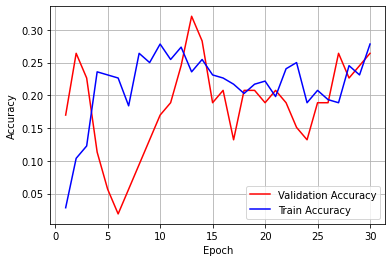

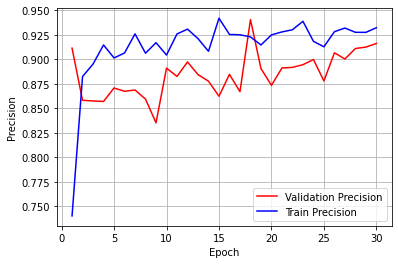

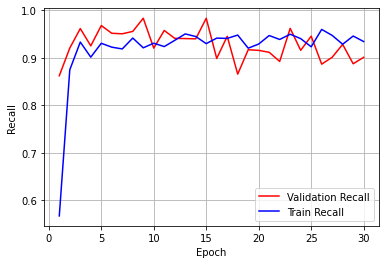

In [77]:
# plot "accuracy" vs epoch
vy = history.history['val_acc']
ty = history.history['acc']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation Accuracy")
ax.plot(x,ty,'b',label = "Train Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# plot "Precision" vs epoch
vy = history.history['val_precision_m']
ty = history.history['precision_m']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation Precision")
ax.plot(x,ty,'b',label = "Train Precision")
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# plot "Recall" vs epoch
vy = history.history['val_recall_m']
ty = history.history['recall_m']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation Recall")
ax.plot(x,ty,'b',label = "Train Recall")
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')
plt.legend()
plt.grid()
plt.show()

In [83]:
# Testing on Validation Images
X_temp = X_val.copy()
X_temp['A'] = X_temp['B'] = X_temp['C'] = X_temp['D'] = int(0)

test_generator = test_DataGenerator.flow_from_dataframe(
        dataframe=X_temp,
        directory=project_root_folder + 'Resized/masks/',
        x_col="ImageId",
        y_col=["A","B","C","D"],
        target_size=(512,256),
        batch_size=10,
        class_mode='raw')

MCXISU_pred_perc_val = MCXISU_model.predict(test_generator,verbose=1)
MCXISU_pred_val = (MCXISU_pred_perc_val > 0.5).astype(np.uint8)


Found 53 validated image filenames.
6/6 [==============================] - 1s 93ms/step


In [103]:
MCXISU_pred_val[0:5]

array([[0, 1, 1, 1],
       [1, 1, 1, 0],
       [0, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 0]], dtype=uint8)

In [104]:
X_val.head(n=5)

ClassId   ImageId  A  B  C  D
212      1047.png  0  1  0  1
213      1048.png  0  1  1  1
214      1049.png  1  1  1  0
215      1050.png  0  1  1  1
216      1051.png  1  0  1  1

In [102]:
A_cm = cm(X_val['A'], MCXISU_pred_val[:,0])
B_cm = cm(X_val['B'], MCXISU_pred_val[:,1])
C_cm = cm(X_val['C'], MCXISU_pred_val[:,2])
D_cm = cm(X_val['D'], MCXISU_pred_val[:,3])

A_acc = (A_cm[0][0] + A_cm[1][1]) / (A_cm[0][0] + A_cm[0][1] + A_cm[1][0] + A_cm[1][1]) * 100
B_acc = (B_cm[0][0] + B_cm[1][1]) / (B_cm[0][0] + B_cm[0][1] + B_cm[1][0] + B_cm[1][1]) * 100
C_acc = (C_cm[0][0] + C_cm[1][1]) / (C_cm[0][0] + C_cm[0][1] + C_cm[1][0] + C_cm[1][1]) * 100
D_acc = (D_cm[0][0] + D_cm[1][1]) / (D_cm[0][0] + D_cm[0][1] + D_cm[1][0] + D_cm[1][1]) * 100

print('Confusion Matrix A:\n' + str(A_cm))
print('Confusion Matrix B:\n' + str(B_cm))
print('Confusion Matrix C:\n' + str(C_cm))
print('Confusion Matrix D:\n' + str(D_cm))

print('Accuracy A: ' + str(round(A_acc,2)))
print('Accuracy B: ' + str(round(B_acc,2)))
print('Accuracy C: ' + str(round(C_acc,2)))
print('Accuracy D: ' + str(round(D_acc,2)))

Confusion Matrix A:
[[ 4 10]
 [ 7 32]]
Confusion Matrix B:
[[ 0  2]
 [ 0 51]]
Confusion Matrix C:
[[ 2  5]
 [ 9 37]]
Confusion Matrix D:
[[18 10]
 [14 11]]
Accuracy A: 67.92
Accuracy B: 96.23
Accuracy C: 73.58
Accuracy D: 54.72


**Observations:**

Xception based Classification is more accurate when applied onto an ISU-net generated mask, but is still overfitting to the data. The high Precision and Recall rates tell us that the predictions more closely match the actual values for the validation set. However, the bias in the dataset still skews the Xception model's predictions.

### Multi-Class Classifier Using Custom Convolutional Neural Network ###


In this section, we will use a custom CNN for the Multi-Class Classification Problem. The objective is to rule out that the inaccuracies above are caused by some inherent inconsistency of Xception model being used above.

In [105]:
# Loading training images from the hard drive
X_images = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH, 3), dtype=np.uint8)
for n in range (0,len(X_master)):
    path = project_root_folder + 'Resized/real/' + str(X_master.iloc[n]['ImageId'])
    img = PIL_Image.open(path)
    X_images[n] = img

In [106]:
# Custom CNN

#2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (IMG_COMP_HEIGHT, IMG_COMP_WIDTH, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(4, activation='sigmoid')(drop4)

model_MCC = keras.Model(inputs=inp, outputs=out)
model_MCC.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
print(model_MCC.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 512, 3)]     0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 256, 512, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 256, 32)      0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 256, 32)      128       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128, 256, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 128, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 128, 32)     

In [107]:
# Split Dataset into Test and Train

X_train, X_test, y_train, y_test = train_test_split(X_images, X_master[['A','B','C','D']], test_size = 0.20, random_state = 0)
#y_train = y_train[['A','B','C','D']]
#y_test = y_test[['A','B','C','D']]

In [108]:
# Training the model 
history = model_MCC.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 50, 
                         verbose = 1, 
                         epochs = 30,
                         validation_split = 0.1,
                         shuffle = False
                     )

Epoch 1/30
4/4 [==============================] - 1s 301ms/step - loss: 4.7606 - accuracy: 0.2053 - val_loss: 30.0383 - val_accuracy: 0.8182
Epoch 2/30
4/4 [==============================] - 1s 146ms/step - loss: 4.1902 - accuracy: 0.2421 - val_loss: 30.0383 - val_accuracy: 0.8182
Epoch 3/30
4/4 [==============================] - 1s 148ms/step - loss: 3.9403 - accuracy: 0.1895 - val_loss: 30.0383 - val_accuracy: 0.8182
Epoch 4/30
4/4 [==============================] - 1s 149ms/step - loss: 3.8120 - accuracy: 0.2474 - val_loss: 27.6252 - val_accuracy: 0.8182
Epoch 5/30
4/4 [==============================] - 1s 149ms/step - loss: 3.7573 - accuracy: 0.3105 - val_loss: 27.8728 - val_accuracy: 0.2727
Epoch 6/30
4/4 [==============================] - 1s 149ms/step - loss: 3.7219 - accuracy: 0.2368 - val_loss: 30.8380 - val_accuracy: 0.0000e+00
Epoch 7/30
4/4 [==============================] - 1s 151ms/step - loss: 3.6353 - accuracy: 0.2632 - val_loss: 34.9094 - val_accuracy: 0.0000e+00
Epoch

In [123]:
MCC_pred_perc = model_MCC.predict(np.array(X_test))
MCC_pred = (MCC_pred_perc  > 0.5).astype(np.uint8)
MCC_pred[0:5]

array([[0, 0, 1, 0],
       [0, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=uint8)

In [127]:
y_test.head()

ClassId  A  B  C  D
110      1  1  1  0
97       1  1  1  1
83       0  1  1  1
8        1  1  1  0
161      1  1  1  0

In [128]:
A_cm = cm(y_test['A'], MCC_pred[:,0])
B_cm = cm(y_test['B'], MCC_pred[:,1])
C_cm = cm(y_test['C'], MCC_pred[:,2])
D_cm = cm(y_test['D'], MCC_pred[:,3])

A_acc = (A_cm[0][0] + A_cm[1][1]) / (A_cm[0][0] + A_cm[0][1] + A_cm[1][0] + A_cm[1][1]) * 100
B_acc = (B_cm[0][0] + B_cm[1][1]) / (B_cm[0][0] + B_cm[0][1] + B_cm[1][0] + B_cm[1][1]) * 100
C_acc = (C_cm[0][0] + C_cm[1][1]) / (C_cm[0][0] + C_cm[0][1] + C_cm[1][0] + C_cm[1][1]) * 100
D_acc = (D_cm[0][0] + D_cm[1][1]) / (D_cm[0][0] + D_cm[0][1] + D_cm[1][0] + D_cm[1][1]) * 100

print('Confusion Matrix A:\n' + str(A_cm))
print('Confusion Matrix B:\n' + str(B_cm))
print('Confusion Matrix C:\n' + str(C_cm))
print('Confusion Matrix D:\n' + str(D_cm))

print('Accuracy A: ' + str(round(A_acc,2)))
print('Accuracy B: ' + str(round(B_acc,2)))
print('Accuracy C: ' + str(round(C_acc,2)))
print('Accuracy D: ' + str(round(D_acc,2)))

Confusion Matrix A:
[[10  0]
 [43  0]]
Confusion Matrix B:
[[ 1  0]
 [19 33]]
Confusion Matrix C:
[[ 9  1]
 [36  7]]
Confusion Matrix D:
[[32  9]
 [ 6  6]]
Accuracy A: 18.87
Accuracy B: 64.15
Accuracy C: 30.19
Accuracy D: 71.7


**Observations**

It can be seen that the custom 'light-weight' CNN performs worse than the Xception model in terms of accuracy. Fine tuning this model would achieve better accuracy, but the objective of this step has been satisfied: The cause of the low accuracies is NOT the Xception model

### Support Vector Machine (SVM) for Binary Image Classification ###

In this section, we try a "shallow-learning" technique to classify the images. 

A Support Vector Machine Classifier (SVM) has been chosen because SVM's have been used to successfully identify hand-written digits. This is because SVMs use a hyperplane to separate out related "features" in a vector. When an image is passed in as a vector, the SVM partitions out the image based on the features of the image.

for this reason, before we can pass an image to the SVM, we must first process it to extract or accentuate its features. Several techniques were experimented with for feature extraction:
- Gaussian Blurring to remove noise
- Edge Detection
- Hue-Saturation Transformation
- Local Binary Pattern 
- Laplace Transformation
- Edge Sharpening by using Gaussian Kernel

Once transformed, the images were passed to the SVM for training, with the associated labels.

In [129]:
X_images_transformed = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH), dtype=np.uint8)
path = project_root_folder + 'Resized/real/'

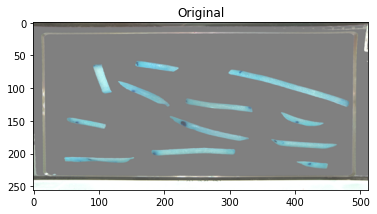

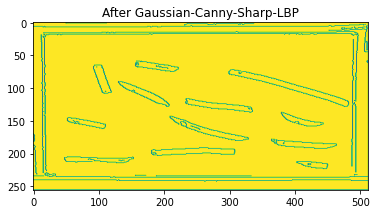

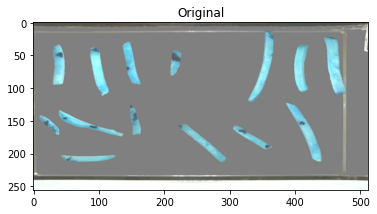

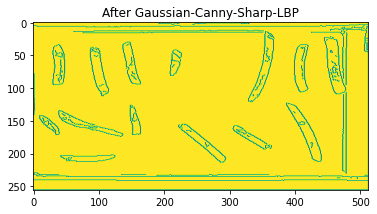

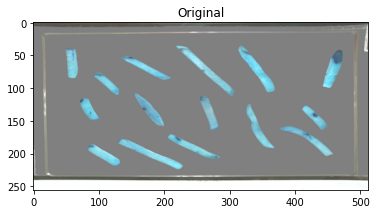

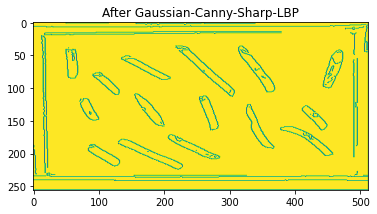

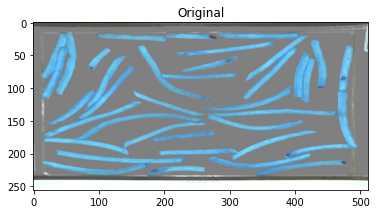

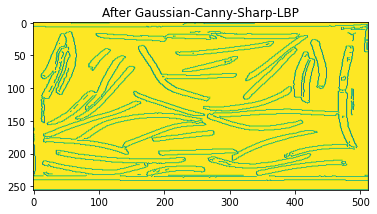

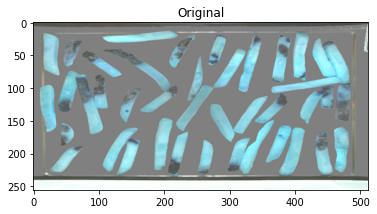

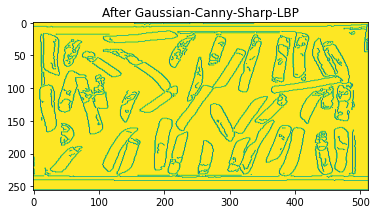

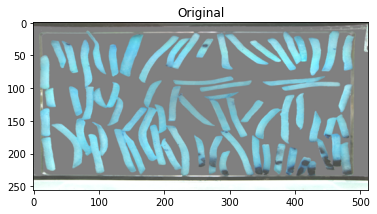

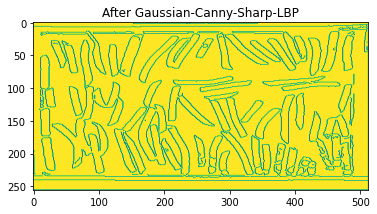

In [132]:
for n in range (0,len(X_master)):

    orig_img = cv2.imread(path + str(X_master.iloc[n]['ImageId']), cv2.IMREAD_COLOR)
    # plt.imshow(orig_img),plt.title('Original')
    # plt.show()

    # Remove noise by blurring with an automated Gaussian filter
    img_gaussian = cv2.GaussianBlur(orig_img, (3, 3), 0)
    # Detect Edges
    edges2 = cv2.Canny(img_gaussian, 50, 100)
    # Sharpen image by using reverse Gaussian
    kernel = np.ones((5,5),np.float32) * -1
    kernel[2][2] = 15
    sharp_img2 = cv2.filter2D(edges2,-1,kernel = kernel)
    # plt.imshow(sharp_img2),plt.title('Gaussian-Canny-Sharp')
    # plt.show()  
    
    # Local Binary Pattern (LBP)
    # https://www.geeksforgeeks.org/create-local-binary-pattern-of-an-image-using-opencv-python/
    def get_pixel(img, center, x, y): 
        new_value = 0
        try: 
            # If local neighbourhood pixel  
            # value is greater than or equal 
            # to center pixel values then  
            # set it to 1 
            if img[x][y] >= center: 
                new_value = 1
        except: 
            # Exception is required when  
            # neighbourhood value of a center 
            # pixel value is null i.e. values 
            # present at boundaries. 
            pass
        return new_value 
       
    # Function for calculating LBP 
    def lbp_calculated_pixel(img, x, y): 
        center = img[x][y] 
        val_ar = [] 
          
        # top_left 
        val_ar.append(get_pixel(img, center, x-1, y-1)) 
        # top 
        val_ar.append(get_pixel(img, center, x-1, y)) 
        # top_right 
        val_ar.append(get_pixel(img, center, x-1, y + 1)) 
        # right 
        val_ar.append(get_pixel(img, center, x, y + 1)) 
        # bottom_right 
        val_ar.append(get_pixel(img, center, x + 1, y + 1)) 
        # bottom 
        val_ar.append(get_pixel(img, center, x + 1, y)) 
        # bottom_left 
        val_ar.append(get_pixel(img, center, x + 1, y-1)) 
        # left 
        val_ar.append(get_pixel(img, center, x, y-1)) 
        # Now, we need to convert binary 
        # values to decimal 
        power_val = [1, 2, 4, 8, 16, 32, 64, 128] 
        val = 0
        for i in range(len(val_ar)): 
            val += val_ar[i] * power_val[i] 
        return val 
    
    dst = sharp_img2
    height, width = dst.shape 
 
    img_lbp = np.zeros((height, width), np.uint8) 
    for i in range(0, height): 
        for j in range(0, width): 
            img_lbp[i, j] = lbp_calculated_pixel(dst, i, j) 
    # plt.imshow(orig_img),plt.title('Original Image')
    # plt.imshow(img_lbp),plt.title('Gaussian-Canny-Sharp-LBP')
    # plt.show()
    
    # Store transformed images
    X_images_transformed[n] = img_lbp

    if n%50 == 0:
      plt.imshow(orig_img),plt.title('Original')
      plt.show()
      plt.imshow(img_lbp),plt.title('After Gaussian-Canny-Sharp-LBP')
      plt.show()

In [133]:
# Saving transformed image to HD vector to save time
# Saving X_images_transformed
f = open(project_root_folder + 'Resized/Transformed/transformed_images.pkl', 'wb')
pickle.dump(X_images_transformed, f)
f.close()

In [154]:
# Loading X_images_transformed
f = open(project_root_folder + 'Resized/Transformed/transformed_images.pkl', 'rb')
X_images_transformed = pickle.load(f)
f.close()

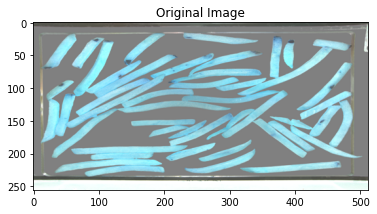

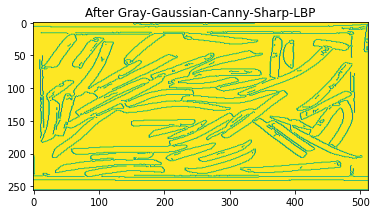

In [155]:
idx = random.randint(0,len(X_images_transformed))

orig_img = cv2.imread(path + str(X_master.iloc[idx]['ImageId']))
plt.imshow(orig_img),plt.title('Original Image')
plt.show()
plt.imshow(X_images_transformed[idx]),plt.title('After Gray-Gaussian-Canny-Sharp-LBP')
plt.show()

In [156]:
# Flatten X_images_transformed
X_images_transformed = X_images_transformed.reshape((len(X_images_transformed), -1))

In [157]:
# Feature Scaling 
scaler = MinMaxScaler()
norm_X_images_transformed = scaler.fit_transform(X_images_transformed)

# Definiting SVM Classifier
SVM_classifier = svm.SVC(gamma=0.001, kernel='rbf')

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_images_transformed, np.array(X_master['D']), test_size = 0.20, random_state = 0)

# Training SVM Classifier only on the B column
SVM_classifier.fit(X_train, y_train)

# Training SVM Classifier
SVM_pred = SVM_classifier.predict(X_test)


In [158]:
SVM_pred[0:5]

array([0, 0, 0, 0, 0])

In [160]:
X_master['D'].head(n=5)

0    0
1    1
2    1
3    1
4    1
Name: D, dtype: int64

In [162]:
print('Confusion Matrix:\n' + str(cm(y_test, SVM_pred)))

Confusion Matrix:
[[41  0]
 [12  0]]


**Observations:**

Using SVM for Binary Classification did not yield satisfactory results. This may be due to the inherent bias caused by the dataset, as well as a lack of the ability of our image processing algorithm to extract features in a way that the SVM could identify them. Further image processing, such as Thresholding, would imrpove the chances of features being detected by the SVM. Data bias may be overcome using the mitigation strategies identified previously.

### Image Processing / Feature Engineering Based Classification ###
In this section, we will use a Non Machine Learning based method to Detect and Classify spots.

The process employed is as follows:

1. Gaussian Blurring to denoise the image 
2. Binary Thresholding to filter out fries from the background image, and to make the fries brighter.
3. Apply custom thresholding to filter out the spots on the fries from the fries.
4. The image now contains ONLY the dark spots
5. Identify the connected regions of the image and store them
6. Calculate the area of the connected regions
7. Classify the connected regions based on the known redii of the various defect classes
8. Draw circles around the defect areas

In [163]:
### IMAGE PROCESSING BASED DETECTION ###
'''Using Non Machine Learning method to Detect and Classify spots'''

dark_spots = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH), dtype=np.uint8)
Class_Defect = np.zeros((X_master.shape[0],X_master.shape[1]-1))
path = project_root_folder + 'Resized/real/'

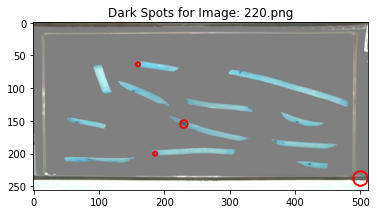

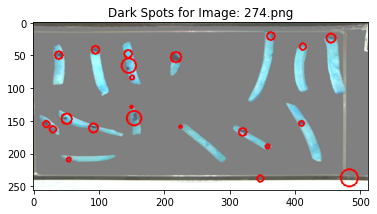

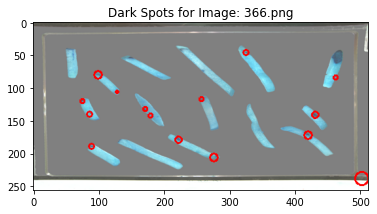

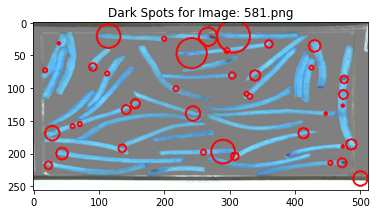

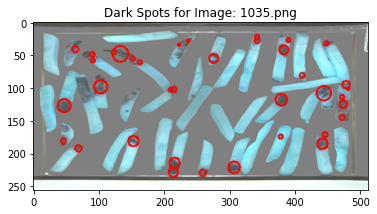

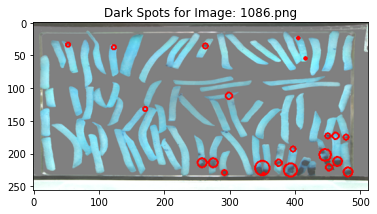

Red circles are the Defects after running through a size filter


In [167]:
crop_image = 0.01 # Percent of image to cutoff from consideration
range_D[1] = area_D*3 # Maximum box/circle size for filtering
range_A[0] = area_A*0.75

for n in range (0,len(dark_spots)):
    orig_img = cv2.imread(path + str(X_master.iloc[n]['ImageId']), cv2.IMREAD_COLOR)
    # plt.imshow(orig_img),plt.title('orig_img')
    # plt.show() 
    img_gaussian = cv2.GaussianBlur(orig_img, (3, 3), 0)
    _ ,thresh = cv2.threshold(img_gaussian, 100, 255, cv2.THRESH_BINARY)
    img_gray2 = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
    img_gray2[img_gray2 >= 230] = 0
    dark_spots[n] = img_gray2

    # Visually identify the dark spots
    
    img = orig_img.copy()
    _, _, boxes, circles = cv2.connectedComponentsWithStats(dark_spots[n])
    # first box is the background
    boxes = boxes[1:]
    filtered_boxes = []
    for x,y,w,h,pixels in boxes:
        if pixels < 10000 and h < range_D[1] and w < range_D[1] and h > 3 and w > 3:
            filtered_boxes.append((x,y,w,h))
    
    # box_sizes = []
    for x,y,w,h in filtered_boxes:
        # cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255),2)
        box_area = w*h

        if x > IMG_COMP_WIDTH*crop_image and x < IMG_COMP_WIDTH*(1-crop_image) and y > IMG_COMP_HEIGHT*crop_image and y < IMG_COMP_HEIGHT*(1-crop_image):
            center = (int(x+w/2), int(y+h/2))
            radius = int(max(w/2,h/2))
            if box_area > range_A[0] and box_area <= range_A[1]:
                Class_Defect[n][0] = 1
                cv2.circle(img, center, radius, (255,0,0),2)
            if box_area > range_B[0] and box_area <= range_B[1]:
                Class_Defect[n][1] = 1
                cv2.circle(img, center, radius, (255,0,0),2)
            if box_area > range_C[0] and box_area <= range_C[1]:
                Class_Defect[n][2] = 1
                cv2.circle(img, center, radius, (255,0,0),2)
            if box_area > range_D[0] and box_area < range_D[1]:
                Class_Defect[n][3] = 1
                cv2.circle(img, center, radius, (255,0,0),2)
    
    if (n%50 == 0):
        plt.imshow(img),plt.title('Dark Spots for Image: ' + str(X_master.iloc[n]['ImageId']))
        plt.show() 

print('Red circles are the Defects after running through a size filter')

In [188]:
A_cm = cm(X_master['A'], Class_Defect[:,0])
B_cm = cm(X_master['B'], Class_Defect[:,1])
C_cm = cm(X_master['C'], Class_Defect[:,2])
D_cm = cm(X_master['D'], Class_Defect[:,3])

A_acc = (A_cm[0][0] + A_cm[1][1]) / (A_cm[0][0] + A_cm[0][1] + A_cm[1][0] + A_cm[1][1]) * 100
B_acc = (B_cm[0][0] + B_cm[1][1]) / (B_cm[0][0] + B_cm[0][1] + B_cm[1][0] + B_cm[1][1]) * 100
C_acc = (C_cm[0][0] + C_cm[1][1]) / (C_cm[0][0] + C_cm[0][1] + C_cm[1][0] + C_cm[1][1]) * 100
D_acc = (D_cm[0][0] + D_cm[1][1]) / (D_cm[0][0] + D_cm[0][1] + D_cm[1][0] + D_cm[1][1]) * 100

print('Confusion Matrix A:\n' + str(A_cm))
print('Confusion Matrix B:\n' + str(B_cm))
print('Confusion Matrix C:\n' + str(C_cm))
print('Confusion Matrix D:\n' + str(D_cm))

print('Accuracy A: ' + str(round(A_acc,2)))
print('Accuracy B: ' + str(round(B_acc,2)))
print('Accuracy C: ' + str(round(C_acc,2)))
print('Accuracy D: ' + str(round(D_acc,2)))

total_accurate = int(A_cm[0][0] + A_cm[1][1] + B_cm[0][0] + B_cm[1][1] + C_cm[0][0] + C_cm[1][1] + D_cm[0][0] + D_cm[1][1])
total_data = len(X_master)*4
Accuracy = round(total_accurate / total_data * 100,2)

print('Average Accuracy: ' + str(Accuracy) + '%')

Confusion Matrix A:
[[  8  35]
 [ 30 192]]
Confusion Matrix B:
[[  1  10]
 [ 13 241]]
Confusion Matrix C:
[[  1  51]
 [ 10 203]]
Confusion Matrix D:
[[  6 189]
 [  0  70]]
Accuracy A: 75.47
Accuracy B: 91.32
Accuracy C: 76.98
Accuracy D: 28.68
Average Accuracy: 68.11%


**Observations:**

This technique works extremely well for identifying the defect areas, with a high degree of accuracy. This is the most accurate method yet of Classifying images.

### Image Segmentation With U-Net and Classification with Image Processing / Feature Engineering (ISUnet2) ###

In this section, we combine our two best methods above for a complete pipeline solution.
1. Image segmentation and defect localization using U-net
2. Defect classification using image processing

Figure ISUnet2-1 shows the Flow Diagram for this Algorithm


Figure ISUnet2-1
![Picture](https://raw.githubusercontent.com/rohaan-ahmed/Master-Repository/master/Savormetrics/Flow%20Diagrams/ISUNet2.png)

In [ ]:
### IMAGE SEGMENTATION WITH U-NET AND CLASSIFICATION WITH IMAGE PROCESSING ###

# # Loading training images and masks from the hard drive
# X_master2 = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH, 3), dtype=np.uint8)
# Y_master2 = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH), dtype=np.uint8)
# for n in range (0,len(X_master)):
#     path = project_root_folder + 'Resized/real/' + str(X_master.iloc[n]['ImageId'])
#     img = PIL_Image.open(path)
#     X_master2[n] = img
# 
#     path = project_root_folder + 'Resized/masks/' + str(X_master.iloc[n]['ImageId'])
#     mask = PIL_Image.open(path)
#     Y_master2[n] = mask

In [ ]:
# # Saving X_master2 and Y_master2 to HD because they always taks long to compute
# f = open(project_root_folder + 'Resized/Transformed/X_master2.pkl', 'wb')
# pickle.dump(X_master2, f)
# 
# f.close()
# f = open(project_root_folder + 'Resized/Transformed/Y_master2.pkl', 'wb')
# pickle.dump(Y_master2, f)
# f.close()

In [169]:
# Loading X_master2 and Y_master2 to HD
f = open(project_root_folder + 'Resized/Transformed/X_master2.pkl', 'rb')
X_master2 = pickle.load(f)
f.close()
f = open(project_root_folder + 'Resized/Transformed/Y_master2.pkl', 'rb')
Y_master2 = pickle.load(f)
f.close()

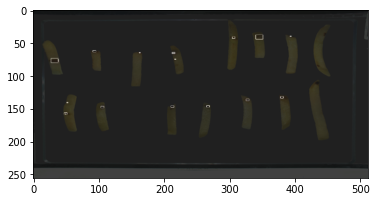

In [171]:
# plotting a random image and mask
idx = random.randint(0, len(X_master2))
img1 = X_master2[idx]
img2 = Y_master2[idx]
plt.imshow(img1)
plt.imshow(img2, cmap='gray', alpha=0.75)
plt.show()

**Deep Learning based Defect Localization / Image Segmentation using ISUNet**

In [172]:
# Building the UNet Model
# https://github.com/zhixuhao/unet/blob/master/model.py

inputs = tf.keras.layers.Input((IMG_COMP_HEIGHT, IMG_COMP_WIDTH, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
ISUnet2_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
ISUnet2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ISUnet2_model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 512, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 256, 512, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 256, 512, 16) 0           conv2d_45[0][0]                  
______________________________________________________________________________________

In [173]:
# Training the Model
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_segmentation.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results = ISUnet2_model.fit(X_master2, Y_master2, validation_split=0.2, batch_size=10, epochs=30, callbacks=callbacks)
results = ISUnet2_model.fit(X_master2, Y_master2, validation_split=0.2, batch_size=10, epochs=30)

Epoch 1/30
22/22 [==============================] - 5s 214ms/step - loss: 0.5454 - accuracy: 0.8760 - val_loss: 0.6481 - val_accuracy: 0.5988
Epoch 2/30
22/22 [==============================] - 4s 177ms/step - loss: 0.3734 - accuracy: 0.7249 - val_loss: 0.6252 - val_accuracy: 0.5980
Epoch 3/30
22/22 [==============================] - 4s 178ms/step - loss: 0.1594 - accuracy: 0.7688 - val_loss: 0.6771 - val_accuracy: 0.5939
Epoch 4/30
22/22 [==============================] - 4s 178ms/step - loss: -0.8736 - accuracy: 0.8107 - val_loss: 0.5509 - val_accuracy: 0.8433
Epoch 5/30
22/22 [==============================] - 4s 179ms/step - loss: -1.3704 - accuracy: 0.8550 - val_loss: -0.4437 - val_accuracy: 0.7093
Epoch 6/30
22/22 [==============================] - 4s 180ms/step - loss: -0.8653 - accuracy: 0.8300 - val_loss: -0.1783 - val_accuracy: 0.9195
Epoch 7/30
22/22 [==============================] - 4s 180ms/step - loss: -1.5035 - accuracy: 0.8787 - val_loss: -0.2230 - val_accuracy: 0.7687

In [174]:
# Saving model to HD to from computing each time
ISUnet2_model.save(project_root_folder + 'Models/ISUnet_model2.h5')

In [ ]:
# Loading model from HD
ISUnet2_model = keras.models.load_model(project_root_folder + 'Models/ISUnet_model2.h5')

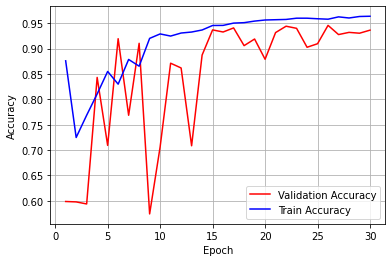

In [175]:
# plot on "accuracy" vs epoch
vy = results.history['val_accuracy']
ty = results.history['accuracy']
x = list(range(1,len(vy)+1))
fig,ax = plt.subplots(1,1)
ax.plot(x,vy,'r',label = "Validation Accuracy")
ax.plot(x,ty,'b',label = "Train Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

9/9 [==============================] - 2s 188ms/step


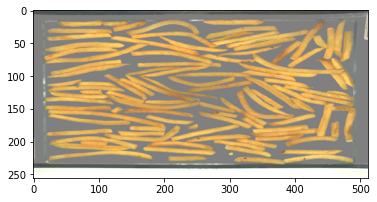

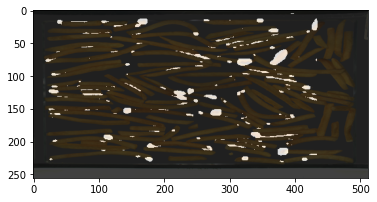

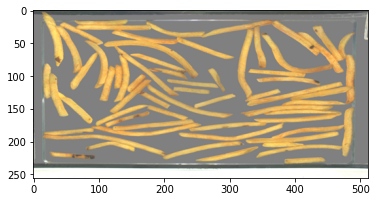

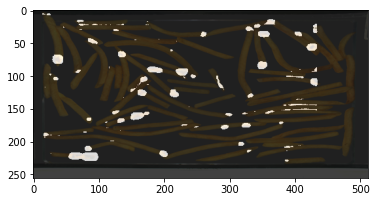

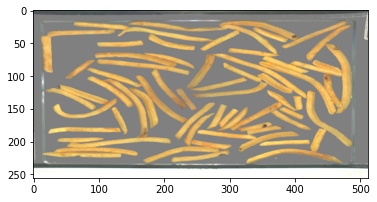

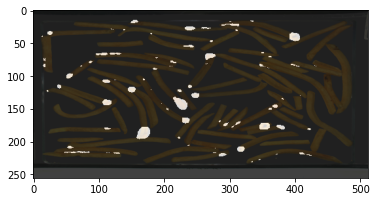

In [176]:
# Testing on a sampling of random Validation Images

pred_perc_ISUnet2 = ISUnet2_model.predict(X_master2[:int(X_master2.shape[0])], verbose=1)
pred_ISUnet2 = (pred_perc_ISUnet2 > 0.5).astype(np.uint8)

idx = random.randint(3, len(pred_ISUnet2))

for ix in range (idx-3, idx):
  plt.imshow(X_master2[ix])
  plt.show()

  plt.imshow(X_master2[ix])
  plt.imshow(np.squeeze(pred_ISUnet2[ix]), cmap='gray', alpha=0.75)
  plt.show()

**Classification Using Image Processing / Feature Engineering**

In [178]:
dark_spots = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH), dtype=np.uint8)
Class_Defect = np.zeros((X_master.shape[0],X_master.shape[1]-1))

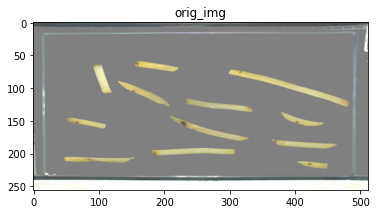

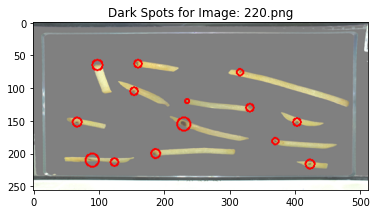

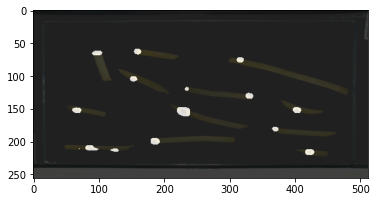

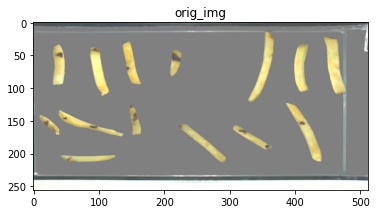

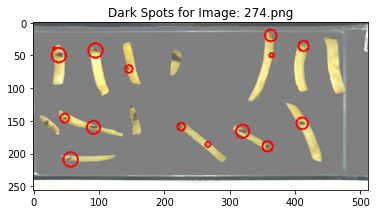

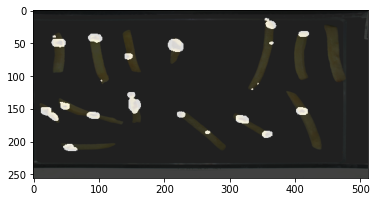

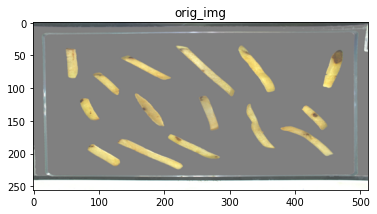

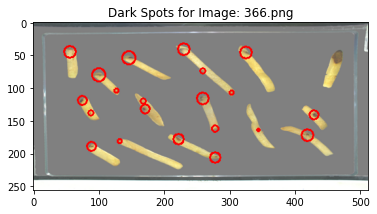

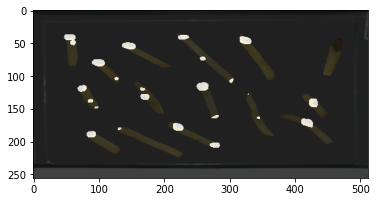

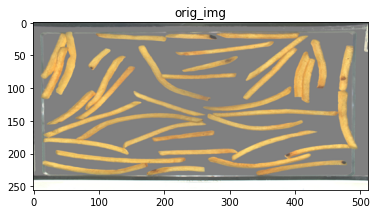

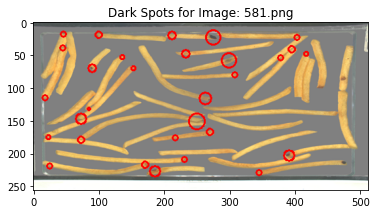

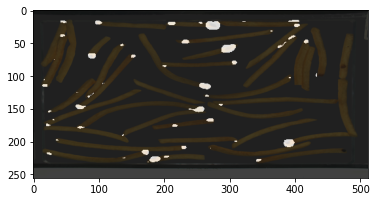

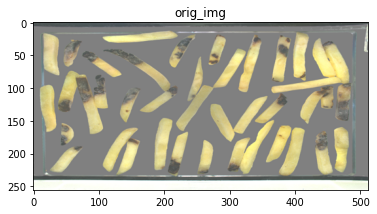

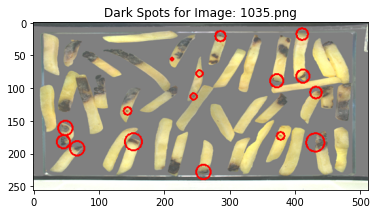

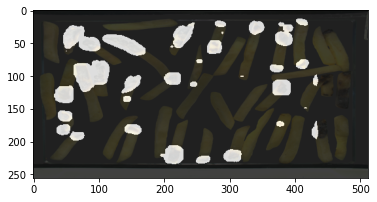

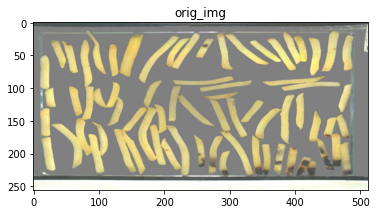

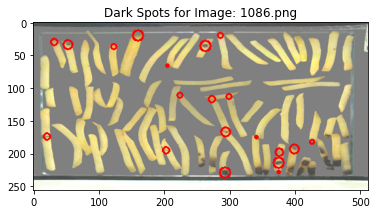

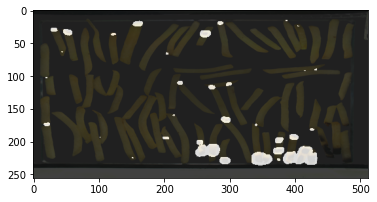

Red circles are the Defects after running through a size filter


In [179]:
# These values were determined after fine tuning for accuracy (below)
# a) crop_image: 0.0% - b) range_D[1]: 150.79631999999998 - c) range_A[0]: 17 - Accuracy: 70.38%
#       crop_image = a/100 # Percent of image to cutoff from consideration
#       range_D[1] = area_D*1 # Maximum box/circle size for filtering
#       range_A[0] = c

crop_image = 0.01 # Percent of image to cutoff from consideration
range_D[1] = area_D*3 # Maximum box/circle size for filtering
range_A[0] = area_A*0.75

for n in range (0,len(dark_spots)):
# for n in range (0,2):
    orig_img = X_master2[n]
    # plt.imshow(orig_img),plt.title('orig_img')
    # plt.show() 
    # img_gaussian = cv2.GaussianBlur(orig_img, (3, 3), 0)
    # _ ,thresh = cv2.threshold(img_gaussian, 100, 255, cv2.THRESH_BINARY)
    # img_gray2 = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
    # img_gray2[img_gray2 >= 230] = 0
    # dark_spots[n] = img_gray2
    
    dark_spots[n] = pred_ISUnet2[n,:,:,0]
    dark_spots[n][dark_spots[n] == 0] = 0
    dark_spots[n][dark_spots[n] == 1] = 255
    # plt.imshow(dark_spots[n]),plt.title('dark_spots[n]')
    # plt.show() 

    # Visually identify the dark spots
    
    img = orig_img.copy()
    mask = dark_spots[n].copy()
    _, _, boxes, circles = cv2.connectedComponentsWithStats(dark_spots[n])
    boxes = boxes[1:] # ignore the first box is the background, its the background
    filtered_boxes = []
    for x,y,w,h,pixels in boxes:
        if pixels < 10000 and h < range_D[1] and w < range_D[1] and h > 3 and w > 3:
            filtered_boxes.append((x,y,w,h))
    
    
    for x,y,w,h in filtered_boxes:
        # cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255),2)
        box_area = w*h

        if x > IMG_COMP_WIDTH*crop_image and x < IMG_COMP_WIDTH*(1-crop_image) and y > IMG_COMP_HEIGHT*crop_image and y < IMG_COMP_HEIGHT*(1-crop_image):
            center = (int(x+w/2), int(y+h/2))
            radius = int(max(w/2,h/2))
            if box_area > range_A[0] and box_area <= range_A[1]:
                Class_Defect[n][0] = 1
                cv2.circle(img, center, radius, (255,0,0),2)
            if box_area > range_B[0] and box_area <= range_B[1]:
                Class_Defect[n][1] = 1
                cv2.circle(img, center, radius, (255,0,0),2)
            if box_area > range_C[0] and box_area <= range_C[1]:
                Class_Defect[n][2] = 1
                cv2.circle(img, center, radius, (255,0,0),2)
            if box_area > range_D[0] and box_area <= range_D[1]:
                Class_Defect[n][3] = 1
                cv2.circle(img, center, radius, (255,0,0),2)
    
    if (n%50 == 0):
        plt.imshow(orig_img),plt.title('orig_img')
        plt.show() 
        plt.imshow(img),plt.title('Dark Spots for Image: ' + str(X_master.iloc[n]['ImageId']))
        plt.show()
        plt.imshow(orig_img)
        plt.imshow(np.squeeze(mask), cmap='gray', alpha=0.75)
        plt.show()

print('Red circles are the Defects after running through a size filter')

In [180]:
A_cm = cm(X_master['A'], Class_Defect[:,0])
A_cm = pd.DataFrame(A_cm, columns=['y_0','y_1'])
A_cm = A_cm.rename(index={0: '0', 1: '1'})

B_cm = pd.DataFrame(cm(X_master['B'], Class_Defect[:,1]), columns=A_cm.columns, index=A_cm.index)
C_cm = pd.DataFrame(cm(X_master['C'], Class_Defect[:,2]), columns=A_cm.columns, index=A_cm.index)
D_cm = pd.DataFrame(cm(X_master['D'], Class_Defect[:,3]), columns=A_cm.columns, index=A_cm.index)

y_0  y_1
0    8   35
1   30  192

In [187]:
A_acc = (A_cm.iloc[0][0] + A_cm.iloc[1][1]) / (A_cm.iloc[0][0] + A_cm.iloc[0][1] + A_cm.iloc[1][0] + A_cm.iloc[1][1]) * 100
B_acc = (B_cm.iloc[0][0] + B_cm.iloc[1][1]) / (B_cm.iloc[0][0] + B_cm.iloc[0][1] + B_cm.iloc[1][0] + B_cm.iloc[1][1]) * 100
C_acc = (C_cm.iloc[0][0] + C_cm.iloc[1][1]) / (C_cm.iloc[0][0] + C_cm.iloc[0][1] + C_cm.iloc[1][0] + C_cm.iloc[1][1]) * 100
D_acc = (D_cm.iloc[0][0] + D_cm.iloc[1][1]) / (D_cm.iloc[0][0] + D_cm.iloc[0][1] + D_cm.iloc[1][0] + D_cm.iloc[1][1]) * 100

print('Accuracy A: ' + str(round(A_acc,2)))
print('Accuracy B: ' + str(round(B_acc,2)))
print('Accuracy C: ' + str(round(C_acc,2)))
print('Accuracy D: ' + str(round(D_acc,2)))

total_accurate = int(A_cm.iloc[0][0] + A_cm.iloc[1][1] + B_cm.iloc[0][0] + B_cm.iloc[1][1] + C_cm.iloc[0][0] + C_cm.iloc[1][1] + D_cm.iloc[0][0] + D_cm.iloc[1][1])
total_data = len(X_master)*4
Accuracy = round(total_accurate / total_data * 100,2)

print('Average Accuracy: ' + str(Accuracy) + '%')

Accuracy A: 75.47
Accuracy B: 91.32
Accuracy C: 76.98
Accuracy D: 28.68
Average Accuracy: 68.11%


Confusion Matrix for Defect A


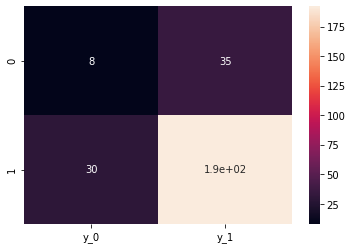

Confusion Matrix for Defect B


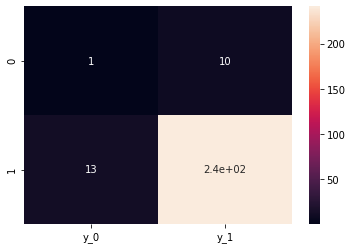

Confusion Matrix for Defect C


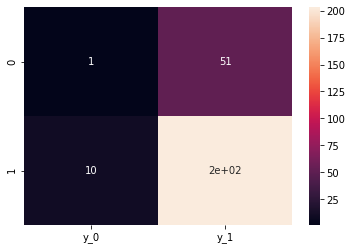

Confusion Matrix for Defect D


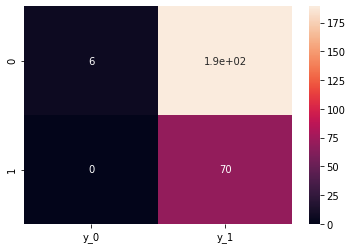

In [186]:
import seaborn as sn
print('Confusion Matrix for Defect A')
sn.heatmap(A_cm, annot=True)
plt.show()
print('Confusion Matrix for Defect B')
sn.heatmap(B_cm, annot=True)
plt.show()
print('Confusion Matrix for Defect C')
sn.heatmap(C_cm, annot=True)
plt.show()
print('Confusion Matrix for Defect D')
sn.heatmap(D_cm, annot=True)
plt.show()

**Observations:**

This technique combines the best methods identified for Classification and Defect Localization. We obtain following accuracy levels:
- Above 90% after Image Segmentation step
- 70% after Classification step

### Future Work ###

There are several areas which can be improved in order to obtain greater accuracy:

**Model Fine Tuning:**
- Fine-tune the ISUnet2 model for better Classification Accuracy

**Model Experimentation**
- Use Image Processing to extract only the spotty regions, and then use this as the input to the Xception Model. This would be the most promising Classification Model architecture, given time.
- Try using U-net for Defect Localization and SVM for Defect Classification

**Dataset Tuning**
- One way of obtaining better results may be to prune the dataset to get rid of any biases. This was not done here because it would drastically reduce the size of the dataset. This can be overcome by obtaining a larger dataset.
- If more data is not available, we can use a Generative Deep Learning model to Generate images with various types of defects. This technique is often used in situations where data is rare (for example, in-orbit videos in the space industry).

### Auxiliary Stuff ###

In [ ]:
# Fine Tuning Parameters
dark_spots = np.zeros((len(X_master), IMG_COMP_HEIGHT, IMG_COMP_WIDTH), dtype=np.uint8)
Class_Defect = np.zeros((X_master.shape[0],X_master.shape[1]-1))

for a in range (0, 10, 2):
  for b in range (1, 6, 1):
    for c in range (1, int(area_A), 2):
      crop_image = a/100 # Percent of image to cutoff from consideration
      range_D[1] = area_D*b # Maximum box/circle size for filtering
      range_A[0] = c

      for n in range (0,len(dark_spots)):
          orig_img = X_master2[n]
          
          dark_spots[n] = pred_ISUnet2[n,:,:,0]
          dark_spots[n][dark_spots[n] == 0] = 0
          dark_spots[n][dark_spots[n] == 1] = 255

          # Visually identify the dark spots
          img = orig_img.copy()
          mask = dark_spots[n].copy()
          _, _, boxes, circles = cv2.connectedComponentsWithStats(dark_spots[n])
          boxes = boxes[1:] # ignore the first box is the background, its the background
          filtered_boxes = []
          for x,y,w,h,pixels in boxes:
              if pixels < 10000 and h < range_D[1] and w < range_D[1] and h > 3 and w > 3:
                  filtered_boxes.append((x,y,w,h))
                  
          for x,y,w,h in filtered_boxes:
              # cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255),2)
              box_area = w*h

              if x > IMG_COMP_WIDTH*crop_image and x < IMG_COMP_WIDTH*(1-crop_image) and y > IMG_COMP_HEIGHT*crop_image and y < IMG_COMP_HEIGHT*(1-crop_image):
                  center = (int(x+w/2), int(y+h/2))
                  radius = int(max(w/2,h/2))
                  if box_area > range_A[0] and box_area <= range_A[1]:
                      Class_Defect[n][0] = 1
                      cv2.circle(img, center, radius, (255,0,0),2)
                  if box_area > range_B[0] and box_area <= range_B[1]:
                      Class_Defect[n][1] = 1
                      cv2.circle(img, center, radius, (255,0,0),2)
                  if box_area > range_C[0] and box_area <= range_C[1]:
                      Class_Defect[n][2] = 1
                      cv2.circle(img, center, radius, (255,0,0),2)
                  if box_area > range_D[0] and box_area < range_D[1]:
                      Class_Defect[n][3] = 1
                      cv2.circle(img, center, radius, (255,0,0),2)

      A_cm = cm(X_master['A'], Class_Defect[:,0])
      A_cm = pd.DataFrame(A_cm, columns=['y_Actual','y_Predicted'])
      A_cm = A_cm.rename(index={0: 'Actual', 1: 'Predicted'})

      B_cm = pd.DataFrame(cm(X_master['B'], Class_Defect[:,1]), columns=A_cm.columns, index=A_cm.index)
      C_cm = pd.DataFrame(cm(X_master['C'], Class_Defect[:,2]), columns=A_cm.columns, index=A_cm.index)
      D_cm = pd.DataFrame(cm(X_master['D'], Class_Defect[:,3]), columns=A_cm.columns, index=A_cm.index)

      total_accurate = int(A_cm.iloc[0][0] + A_cm.iloc[1][1] + B_cm.iloc[0][0] + B_cm.iloc[1][1] + C_cm.iloc[0][0] + C_cm.iloc[1][1] + D_cm.iloc[0][0] + D_cm.iloc[1][1])
      total_data = len(X_master)*4
      Accuracy = round(total_accurate / total_data * 100,2)

      print('a) crop_image: ' + str(crop_image) + '% - b) range_D[1]: ' + str(range_D[1]) + ' - c) range_A[0]: ' + str(range_A[0]) + ' - Accuracy: ' + str(Accuracy) + '%')

a) crop_image: 0.0% - b) range_D[1]: 150.79631999999998 - c) range_A[0]: 1 - Accuracy: 70.38%


KeyboardInterrupt: ignored